# Spam Classifier

In [1]:
#import modules
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Sample data
col_names = ['message', 'label']
messages = pd.read_csv("train_data.csv", header=None, names=col_names)
messages.head()


,message,label
0,It is raining offers today.,1
1,It is raining outside.,0
2,Check out my latest video!,1
3,Make sure you have checked all the important d...,0
4,There are no free lunches.,0


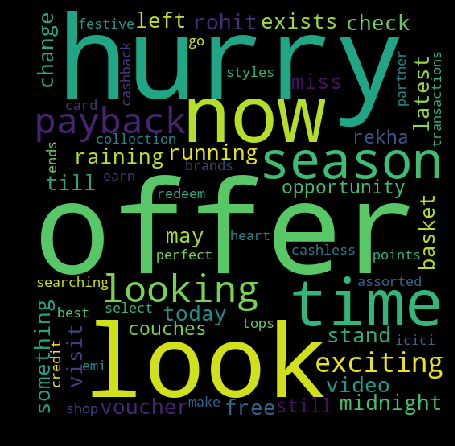

In [3]:
spam_words = ' '.join(list(messages[messages['label']==1]['message']))
spam_words = spam_words.lower()
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize = (8,6), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Preprocessing for text data can help improve the accuracy and model's capacity to deal with data. Hence, next follows the commonly used text data preprocessing steps:<br><br>
1) Making all letter <b>lowercase</b> so that OFFER is same as offer.<br><br>
2) <b>Tokenization</b>: Process of splitting message into pieces and throwing out all the punctuation. Eg, "Hi, Shall we meet tomorrow at 5?" to "Hi shall we meet tomorrow at 5"<br><br>
3) <b>Stemming</b>: Process of identifying a single word for all the derivative forms. Eg, for words - 'shared', 'sharing', saving a single word 'shar'. Porter Stemmer is the most commonly used.<br><br>
4) <b>Removing stop words</b>: Words such as 'a', 'at', 'the', 'is', 'an' do not hold much information and thus would be useful to drop for the classification process.<br><br>
5) <b>n-gram model</b>: Sometimes, context holds much more information than a single word. For instance, 'not good' may change the meaning entirely from treating 'not' and 'good' separately. Therefore, the choice of number of tokens to be treated together can be decided and accordingly an n-gram model can be trained.<br>

In [4]:
def process_message(message, lower_case=True, stem=True, stop_words=True, gram=1):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words)-gram+1):
            w += ' '.join(words[i:i+gram])
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return words

Two approaches to use the data:<br><br>
1) <b>Bag of words</b>: Count the 'term frequency' of each word in the dataset. <br>
$$ P(w) = \frac{\text{Total occurrences of w in dataset}}{\text{Total words in dataset}} $$
<br><br>
$$ P(w|spam) = \frac{\text{Total occurrences of w in spam messages}}{\text{Total words in spam messages}} $$
<br>
2) <b>TF-IDF (Term Frequency - Inverse Document Frequency)</b>: TF remains the same as defined above. IDF is as defined below:<br><br>
$$ IDF(w) = log \frac{\text{Total number of messages}}{\text{Total number of messages containing w}} $$
<br><br>
While term frequency helps shoot up the importance of a term, a very widely used term may become less informative and thus is accounted for by IDF. It helps give more weight to words that occur less frequently but convey more information.<br>

Therefore, with the new TF-IDF score defined for each word, the probabilities with Laplace smoothing are computed as follows:<br>

$$ P(w) = \frac{TF(w)*IDF(w)}{\sum_{\text{$\forall$ words x $\in$ dataset}}TF(x)*IDF(x)} $$
<br><br>
$$ P(w|spam) = \frac{TF(w|spam)*IDF(w) + \alpha}{\sum_{\text{$\forall$ words x $\in$ dataset}}TF(x|spam)*IDF(x) + \alpha * \sum_{\text{$\forall$ words x $\in$ dataset}}1} $$
<br><br>
<b>Laplace Smoothing</b>: This is to account for those words that are not seen in the training data even once. For $\alpha > 0$, the probability of a message being spam for a word seen for the first time in the test set does not drop to 0.

In [5]:
spam_dict = {}
not_spam_dict = {}

for idx, message in messages.iterrows():
    words = process_message(message['message'])
    
    for word in words:
        if message['label'] == 0 and word != ' ':
            not_spam_dict[word] = not_spam_dict.get(word,0)+1
        elif message['label'] == 1 and word != ' ':
            spam_dict[word] = spam_dict.get(word,0)+1

SyntaxError: unexpected EOF while parsing (<ipython-input-6-924ad3a2c4ee>, line 1)